In [1]:
import pandas as pd

In [2]:
# instead of importing all the bigrams, it might be simplest just to only generate the econ bigrams
articles = pd.read_csv('../process_articles/processed_articles.csv')

In [3]:
len(articles)

2179

In [4]:
# drop the ones that don't have text
articles = articles.dropna(subset=['text'])

In [5]:
len(articles)

2056

In [66]:
from operator import itemgetter
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
nltk.download('punkt')


def get_term_ngrams(text, n, term):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ''.join(grams) for grams in n_grams if term in grams]


def ngram_term_counts(ngram):
    # create word count dictionary
    word_count = {}

    for word in ngram:
        if word in word_count.keys():
            cur_val = word_count[word]
            cur_val += 1
            word_count[word] = cur_val
        else:
            word_count[word] = 1

    # sort the dictionary
    word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}

    return word_count


def get_top_n_ngrams(df, term, top_n, ngram, stopwords):
    # generate and store the ngrams for each article that contain the term
    df[term+'_bigram'] = df['cleaned_text_wspaces'].map(lambda x: get_term_ngrams(x, ngram, term))
    print(df[term+'_bigram'].head(10))
    print()

    # calculate and store ngram count dictionary for each article
    df[term+'_bigram_count'] = df[term+'_bigram'].map(lambda x: ngram_term_counts(x))
    print(df[term+'_bigram_count'].head(10))

    # create an empty dictionary to store the term-counts for each quarter
    quarters = list(df['year_quarter'].unique())
    quarters.sort()

    quarter_ngrams = {}
    for quarter in quarters:
        quarter_ngrams[quarter] = {}
    print(quarter_ngrams)

    # calculate the complete list of ngrams and their counts for each quarter
    for index, row in articles.iterrows():
        year_quarter = row['year_quarter']

        quarter_ngrams[year_quarter] = {i: row[term+'_bigram_count'].get(i, 0) + quarter_ngrams[year_quarter].get(i, 0) 
            for i in set(row[term+'_bigram_count']).union(quarter_ngrams[year_quarter])}
    print(quarter_ngrams)

    # drop "stopword"-esque ngrams (ones paired with things like 和、对、的, etc.)
    for quarter in quarter_ngrams:
        for stopword in stopwords:
            if stopword in quarter_ngrams[quarter].keys():
                quarter_ngrams[quarter].pop(stopword)

    # get the top n most common terms for each quarter
    top_n_pairs = {}
    for quarter in quarter_ngrams:
        top_n_pairs[quarter] = dict(sorted(quarter_ngrams[quarter].items(), key=itemgetter(1), reverse=True)[:top_n])    
    print(top_n_pairs)

    # extract the list of the most common terms for all quarters
    terms = []
    for quarter in top_n_pairs:
        for term in top_n_pairs[quarter]:
            terms.append(term)
    terms = list(set(terms))

    return terms
    
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from ipynb.fs.full.frequency_analysis import quarter_count

path = '/Users/calebharding/Documents/BYU/2023-2024/China_Project/qiushi_venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/NotoSansSC-Regular.ttf'
font = font_manager.FontProperties(fname=path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = font.get_name()

def graph_top_n_ngrams(terms, title, y_lim=None):
    fig, axs = plt.subplots(len(terms), sharex=True, sharey=True, figsize=(6, 10))

    clrs = sns.color_palette(n_colors=len(terms))

    for index, term in enumerate(terms):
        term_quarter_count = quarter_count(articles, term)
        xvals = list(term_quarter_count.keys())[:-1]
        yvals = list(term_quarter_count.values())[:-1]

        axs[index].plot(xvals, yvals, c=clrs[index])
        axs[index].legend([term])
        axs[index].set(xlabel='Quarter')
        axs[index].grid()
        axs[index].label_outer()
        axs[index].tick_params(axis='x', rotation=50)

        if y_lim:
            axs[index].set_ylim(y_lim)

    fig.suptitle(title)
    fig.supylabel("Instance Count")
    fig.tight_layout()

    # plt.savefig(f"../visuals/{save_string}frequency.png", bbox_inches='tight')
    plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/calebharding/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
terms = get_top_n_ngrams(articles, "经济", 2, 2, ["和经济", "经济和","经济的", "的经济",'经济在','经济上','对经济','经济要','是经济'])

0                                         [中央经济, 经济工作]
1                 [实体经济, 经济为, 无穷的经济, 经济价值, 发展经济, 经济政策]
2    [中央经济, 经济工作, 把经济, 经济活动, 的经济, 经济增长, 无穷的经济, 经济价值...
3      [财富经济, 经济财富, 换取经济, 经济的, 对经济, 经济发展, 碳循环经济, 经济发展]
4    [海洋经济, 经济保护, 中央经济, 经济工作, 海洋经济, 经济建设, 海洋经济, 经济保...
5    [后经济, 经济恢复, 我国经济, 经济回升, 于经济, 经济增长, 尊重经济, 经济规律,...
6                              [对经济, 经济建设, 增加经济, 经济建设]
7    [数字经济, 经济增加值, 数字经济, 经济做, 的经济, 经济增长点, 未来经济, 经济发...
8    [中央经济, 经济工作, 中央经济, 经济工作, 年经济, 经济工作, 一步经济, 经济工作...
9    [中央经济, 经济工作, 国家经济, 经济发展, 推动经济, 经济增长, 对经济, 经济工作...
Name: 经济_bigram, dtype: object

0                               {'中央经济': 1, '经济工作': 1}
1    {'实体经济': 1, '经济为': 1, '无穷的经济': 1, '经济价值': 1, '...
2    {'的经济': 2, '中央经济': 1, '经济工作': 1, '把经济': 1, '经济...
3    {'经济发展': 2, '财富经济': 1, '经济财富': 1, '换取经济': 1, '...
4    {'海洋经济': 15, '经济发展': 3, '经济保护': 2, '中央经济': 2, ...
5    {'经济回升': 2, '后经济': 1, '经济恢复': 1, '我国经济': 1, '于...
6                     {'经济建设': 2, '对经济': 1, '增加经济': 1}
7    {'数字经济': 5, '开放型经济': 3, '经济做

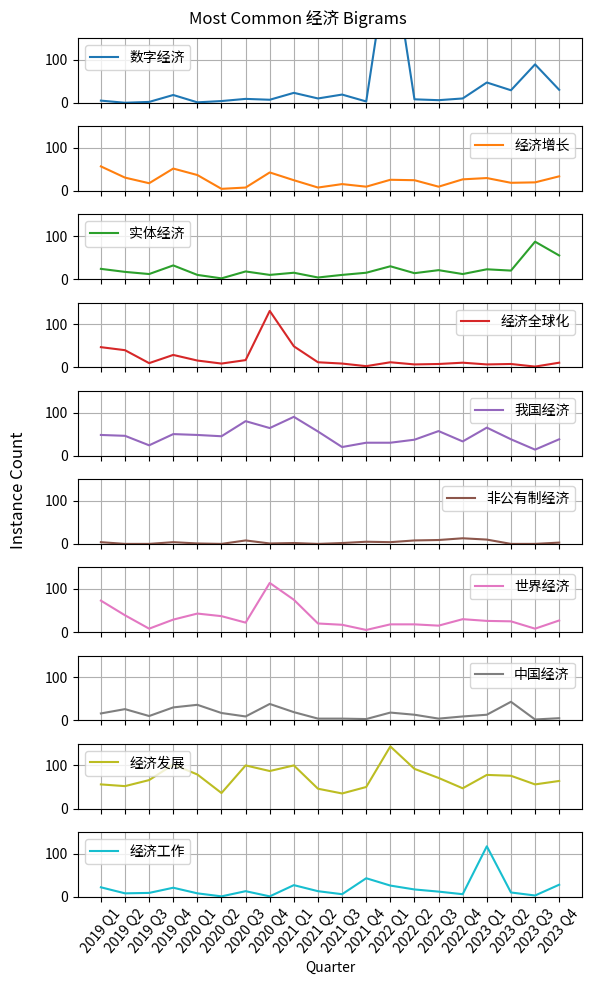

In [65]:
graph_top_n_ngrams(terms, "Most Common 经济 Bigrams", y_lim=[0, 150])